In [1]:
!pip install earthpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.4 MB/s eta 0:00:0000:0100:01


In [3]:
import matplotlib.pyplot as plt

import numpy as np
import earthpy.plot as ep
import seaborn as sns
import earthpy.spatial as es

import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat

import pandas as pd

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tqdm import tqdm
from numpy.random import seed
from time import time

2024-07-09 08:11:46.487832: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 08:11:46.487932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 08:11:46.617866: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [16]:
data = loadmat('/kaggle/input/xuzhou-hyspex-dataset/data.mat')
X = data['all_x']

In [17]:
X.shape

(130000, 436)

In [18]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'all_y', 'all_x', 'x', 'y'])

In [19]:
data['all_y'].shape

(130000, 1)

In [20]:
df = pd.DataFrame(X)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,426,427,428,429,430,431,432,433,434,435
0,0.012496,0.012497,0.012379,0.010932,0.010781,0.013117,0.013523,0.013883,0.014924,0.016615,...,0.000603,0.000382,0.000259,0.000221,0.000085,0.000011,0.000000,0.000196,0.000000,0.000030
1,0.011224,0.012468,0.012385,0.012742,0.012231,0.012749,0.012286,0.013841,0.014833,0.016876,...,0.000580,0.000319,0.000291,0.000336,0.000203,0.000000,0.000019,0.000084,0.000232,0.000115
2,0.013346,0.010584,0.012411,0.012475,0.010207,0.012465,0.014034,0.014644,0.014905,0.015467,...,0.000630,0.000512,0.000256,0.000310,0.000170,0.000116,0.000084,0.000100,0.000106,0.000000
3,0.012064,0.011809,0.011738,0.011408,0.011713,0.010991,0.013067,0.014298,0.014862,0.014745,...,0.000630,0.000512,0.000256,0.000310,0.000170,0.000116,0.000084,0.000100,0.000106,0.000000
4,0.012826,0.013072,0.011363,0.011872,0.011231,0.012533,0.013956,0.013996,0.014480,0.016959,...,0.000594,0.000552,0.000115,0.000339,0.000029,0.000007,0.000152,0.000140,0.000086,0.000039


In [21]:
df.shape

(130000, 436)

In [22]:
df['class'] = data['all_y'].ravel()

In [23]:
df['class'].shape

(130000,)

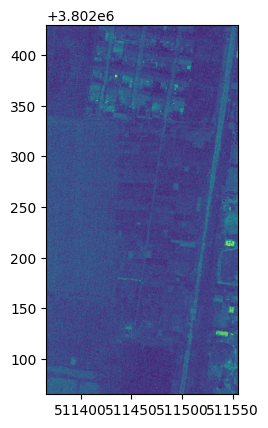

(436, 500, 260)


In [24]:
import rasterio
from rasterio.plot import show
from matplotlib import pyplot as plt
import numpy as np

img = rasterio.open('/kaggle/input/xuzhou-hyspex-data-set/image/image.img')
show(img)

full_img = img.read()
print(full_img.shape)

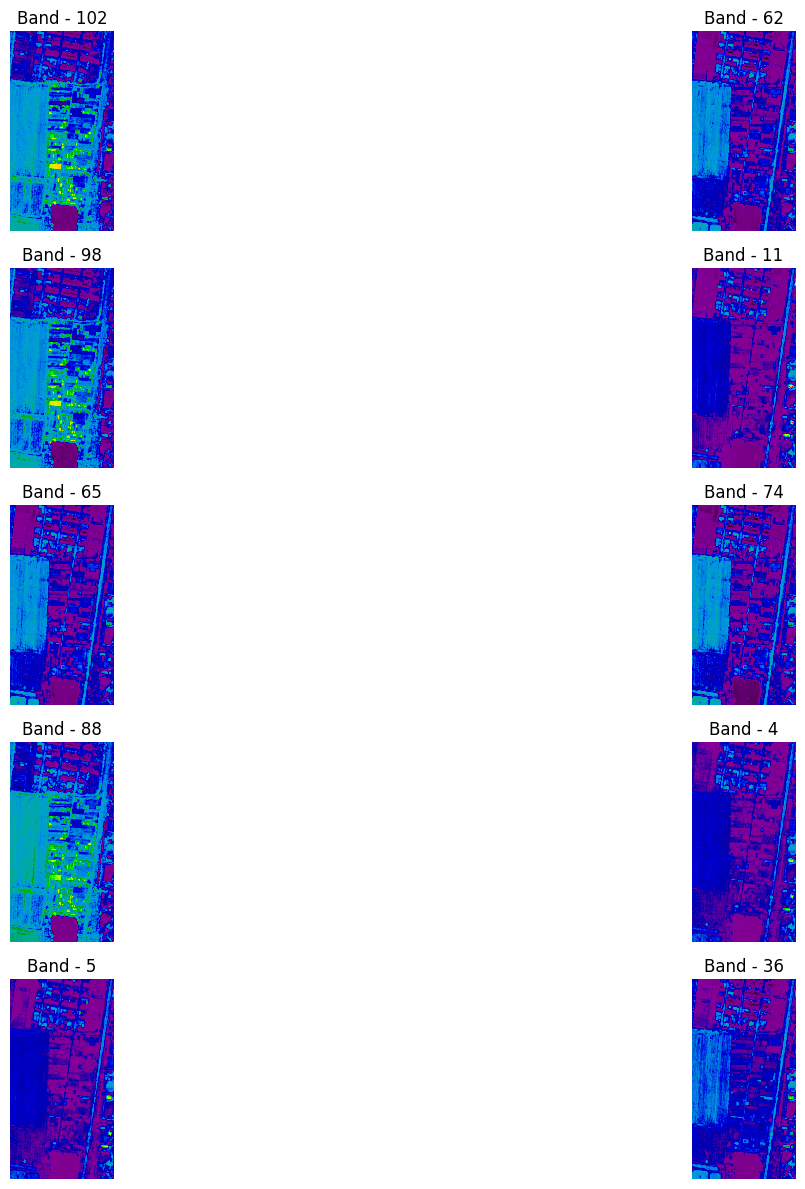

In [25]:
full_img = np.transpose(full_img , (1,2,0))
fig = plt.figure(figsize = (20, 12))

ax = fig.subplots(5,2)

for i in range(5):
    for j in range(2):
        c = np.random.randint(103)
        ax[i][j].imshow(full_img[:, :, c], cmap='nipy_spectral')
        ax[i][j].axis('off')
        ax[i][j].title.set_text(f"Band - {c}")
        c+=1

plt.tight_layout()
plt.show()

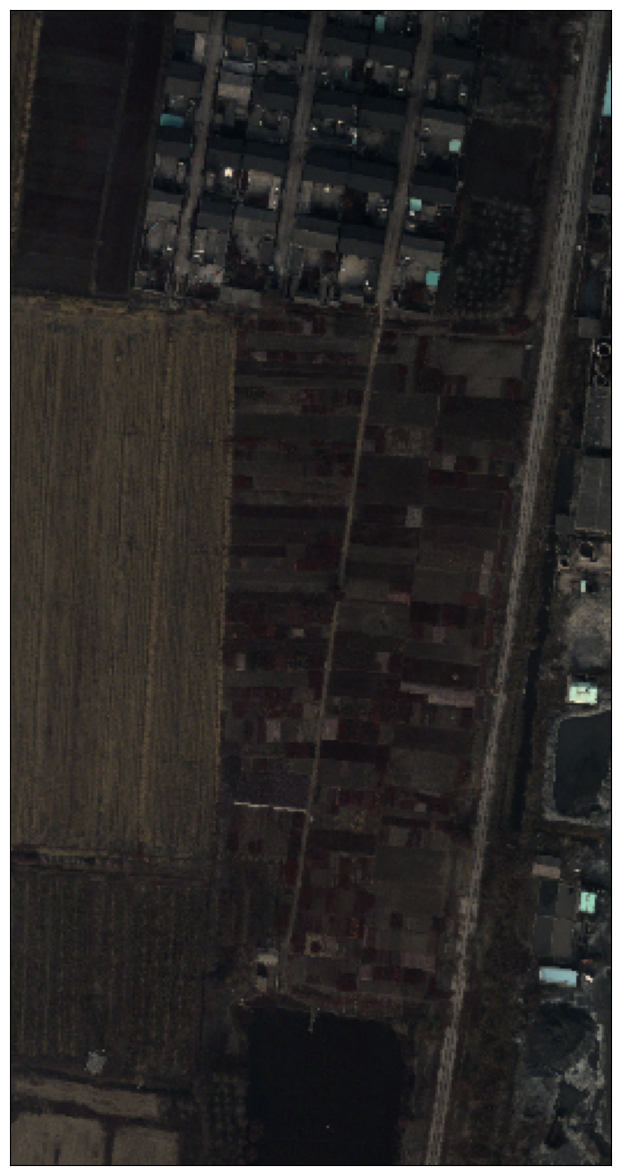

In [26]:
mdata = np.moveaxis(full_img, -1, 0)

ep.plot_rgb(mdata, (29, 19, 9), figsize=(15, 15)) 

plt.show()

In [28]:
df.shape

(130000, 437)

In [27]:
t_df = df[df['class']!=0]
t_df

,0,1,2,3,4,5,6,7,8,9,...,427,428,429,430,431,432,433,434,435,class
0,0.012496,0.012497,0.012379,0.010932,0.010781,0.013117,0.013523,0.013883,0.014924,0.016615,...,0.000382,0.000259,0.000221,0.000085,0.000011,0.000000,0.000196,0.000000,0.000030,1
1,0.011224,0.012468,0.012385,0.012742,0.012231,0.012749,0.012286,0.013841,0.014833,0.016876,...,0.000319,0.000291,0.000336,0.000203,0.000000,0.000019,0.000084,0.000232,0.000115,1
2,0.013346,0.010584,0.012411,0.012475,0.010207,0.012465,0.014034,0.014644,0.014905,0.015467,...,0.000512,0.000256,0.000310,0.000170,0.000116,0.000084,0.000100,0.000106,0.000000,1
3,0.012064,0.011809,0.011738,0.011408,0.011713,0.010991,0.013067,0.014298,0.014862,0.014745,...,0.000512,0.000256,0.000310,0.000170,0.000116,0.000084,0.000100,0.000106,0.000000,1
4,0.012826,0.013072,0.011363,0.011872,0.011231,0.012533,0.013956,0.013996,0.014480,0.016959,...,0.000552,0.000115,0.000339,0.000029,0.000007,0.000152,0.000140,0.000086,0.000039,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129991,0.011849,0.012768,0.014389,0.013283,0.011724,0.013730,0.014414,0.015124,0.017004,0.017028,...,0.000228,0.000182,0.000157,0.000010,0.000127,0.000077,0.000033,0.000122,0.000074,3
129992,0.012710,0.013685,0.012842,0.012067,0.011223,0.013714,0.013576,0.014367,0.014762,0.015812,...,0.000228,0.000182,0.000157,0.000010,0.000127,0.000077,0.000033,0.000122,0.000074,3
129993,0.012710,0.010244,0.012675,0.011771,0.011223,0.012691,0.013164,0.014276,0.014512,0.015585,...,0.000221,0.000177,0.000130,0.000039,0.000106,0.000113,0.000114,0.000164,0.000076,3
129994,0.011822,0.011964,0.013177,0.011032,0.010964,0.013259,0.013988,0.014092,0.015180,0.014301,...,0.000381,0.000404,0.000305,0.000159,0.000195,0.000089,0.000093,0.000209,0.000124,3


In [30]:
import pandas as pd
import numpy as np

# Create a sample DataFrame with shape (130000, 436)
print("Original shape:", df.shape)

# # Convert DataFrame to NumPy array
array = df.values

# # Reshape the array to (500, 260, 436)
reshaped_array = array.reshape(500, 260, 436)

# # Optionally, convert the reshaped array back to a DataFrame
# # Note: This step is often not required unless you specifically need a DataFrame
# reshaped_df = pd.DataFrame(reshaped_array.reshape(-1, 436))

# # Verify the reshaped DataFrame shape
# print("Reshaped shape:", reshaped_df.shape)


Original shape: (130000, 437)


In [33]:
array = df.values

# # Reshape the array to (500, 260, 436)
reshaped_array = np.reshape(df , (500 , 260 ,437))


In [35]:
reshaped_array.shape

(500, 260, 437)

In [29]:
ind = [i for i in range(1, t_df.shape[-1]-1)]

X = t_df.loc[:, ind]

y = to_categorical(t_df.loc[:, 'class'])

X_scaled = minmax_scale(X, axis = 0);

X_scaled.shape, y.shape

((68877, 435), (68877, 10))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    stratify=y, 
                                                    test_size=0.30)
print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}") 

X_train: (48213, 435)
y_train: (48213, 10)
X_test: (20664, 435)
y_test: (20664, 10)


In [15]:
ip_shape = X_train[1].shape

n_outputs = y_train.shape[1]

X_train[1].ravel().shape

(435,)

In [16]:
X_train = X_train.reshape(-1,435, 1)
X_test = X_test.reshape(-1,435, 1)

In [17]:
model = Sequential(name = 'Xozhou')

model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu', input_shape =(ip_shape[0],1), name = 'Layer1'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Layer2'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Layer3'))

model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer1'))
model.add(Dropout(0.4, name = 'Dropout1'))

model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer4'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer5'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer6'))

model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer2'))
model.add(Dropout(0.4, name = 'Dropout2'))

model.add(Flatten(name = 'Flatten'))

model.add(Dense(25, activation='relu', name = 'DenseLayer'))

model.add(Dense(n_outputs, activation='softmax', name = 'OutputLayer'))


model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Salinas_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Layer1 (Conv1D)                 │ (None, 433, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer2 (Conv1D)                 │ (None, 431, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer3 (Conv1D)                 │ (None, 429, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_Layer1               │ (None, 214, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ (None, 214, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer4 (Conv1D)                 │ (None, 212, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer5 (Conv1D)                 │ (None, 210, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Layer6 (Conv1D)                 │ (None, 208, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_Layer2               │ (None, 104, 32)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout2 (Dropout)              │ (None, 104, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 3328)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DenseLayer (Dense)              │ (None, 25)             │        83,225 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutputLayer (Dense)             │ (None, 10)             │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,829 (471.99 KB)

 Trainable params: 120,829 (471.99 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
hist = model.fit(X_train, 
                       y_train, 
                       epochs = 100, 
                       batch_size = 256 , 
                       validation_data = (X_test, y_test))

Epoch 1/100
  3/189 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.1500 - loss: 2.2998

I0000 00:00:1718745323.665638     120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718745323.688061     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5702 - loss: 1.2578

W0000 00:00:1718745338.199150     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718745339.084720     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


189/189 ━━━━━━━━━━━━━━━━━━━━ 36s 97ms/step - accuracy: 0.5712 - loss: 1.2551 - val_accuracy: 0.9265 - val_loss: 0.2271
Epoch 2/100
  3/189 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9230 - loss: 0.2617 

W0000 00:00:1718745341.881898     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9186 - loss: 0.2522 - val_accuracy: 0.9454 - val_loss: 0.1730
Epoch 3/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9333 - loss: 0.2053 - val_accuracy: 0.9467 - val_loss: 0.1598
Epoch 4/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9409 - loss: 0.1795 - val_accuracy: 0.9534 - val_loss: 0.1382
Epoch 5/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9432 - loss: 0.1698 - val_accuracy: 0.9507 - val_loss: 0.1398
Epoch 6/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9460 - loss: 0.1641 - val_accuracy: 0.9608 - val_loss: 0.1209
Epoch 7/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9467 - loss: 0.1527 - val_accuracy: 0.9559 - val_loss: 0.1327
Epoch 8/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9504 - loss: 0.1472 - val_accuracy: 0.9627 - val_loss: 0.1150
Epoch 9/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9514 - loss: 0.1407 - val_accuracy

In [21]:
loss, acc = model.evaluate(X_test, y_test)

646/646 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9844 - loss: 0.0452


In [22]:
print(f"Accuracy: {acc*100}\nLoss: {loss}")

Accuracy: 98.45625162124634
Loss: 0.04476822912693024


In [24]:
pred = np.argmax(model.predict(X_test), axis=1)

646/646 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [25]:
print(classification_report(pred, np.argmax(y_test, 1),
      target_names = ['1.BARELAND1', '2.LAKES',
                      '3.COALS',
                      '4.CEMENT',
                      '5.CROPS-1',
                      '6.TRESS',
                      '7.BARELAND2',
                      '8.CROPS',
                      '9.RED-TITLE'
                     ]))

              precision    recall  f1-score   support

 1.BARELAND1       0.98      0.99      0.98      7838
     2.LAKES       1.00      1.00      1.00      1204
     3.COALS       0.99      0.98      0.99       838
    4.CEMENT       0.99      1.00      0.99      1551
   5.CROPS-1       0.98      0.99      0.99      3925
     6.TRESS       0.98      0.95      0.96       749
 7.BARELAND2       0.99      0.94      0.96      2205
     8.CROPS       1.00      1.00      1.00      1434
 9.RED-TITLE       0.99      1.00      1.00       920

    accuracy                           0.98     20664
   macro avg       0.99      0.98      0.98     20664
weighted avg       0.98      0.98      0.98     20664



<Axes: >

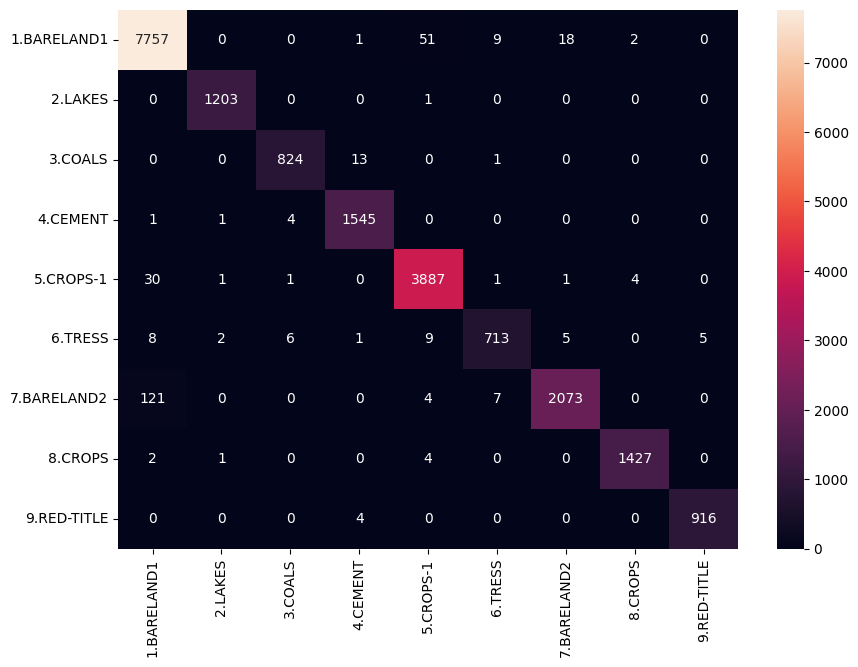

In [26]:
plt.figure(figsize = (10,7))

classes = ['1.BARELAND1', '2.LAKES',
                      '3.COALS',
                      '4.CEMENT',
                      '5.CROPS-1',
                      '6.TRESS',
                      '7.BARELAND2',
                      '8.CROPS',
                      '9.RED-TITLE']

mat = confusion_matrix(np.add(pred, 1), np.add(np.argmax(y_test, 1), 1))

df_cm = pd.DataFrame(mat, index = classes, columns = classes)

sns.heatmap(df_cm, annot=True, fmt='d')


BARELAND1
LAKES
COALS
CEMENT
CROPS-1
TRESS
BARELAND2
CROPS
RED-TITLE